# 2D Poisson problem

In [1]:
from cuqi.problem import BayesianProblem
from cuqi.distribution import Gaussian
from cuqipy_fenics.utilities import ExpressionFromCallable
from cuqipy_fenics.testproblem import FEniCSPoisson2D, FEniCSDiffusion1D
import numpy as np
import cuqi
import cuqipy_fenics
import dolfin as dl
import matplotlib.pyplot as plt

Print CUQIpy and CUQIpy-FEniCS versions:

In [2]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)
print(cuqipy_fenics.__file__)

0+untagged.3470.g36baffb
0+untagged.254.g1a15c30.dirty
/Users/amal/Documents/research_code/CUQI-DTU/CUQIpy-FEniCS/cuqipy_fenics/__init__.py


In [3]:
physical_dim = 1 # choice of physical dimension

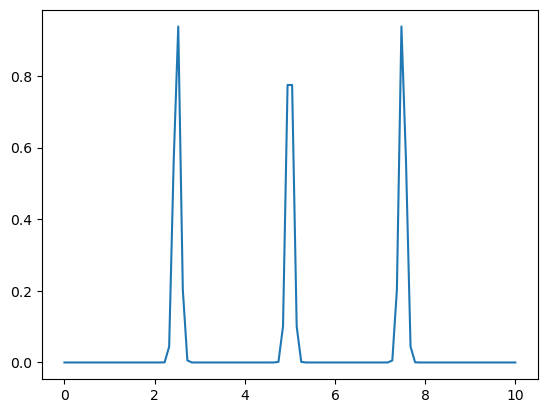

In [4]:
endpoint = 10 # domain length
# f is sum of 3 exponentials at 1/4*endpoint and 1/2*endpoint and 3/4*endpoint

def f(x):
    return np.exp(-100*(x-1/4*endpoint)**2) + np.exp(-100*(x-1/2*endpoint)**2) + np.exp(-100*(x-3/4*endpoint)**2)

#plot f
x = np.linspace(0, endpoint, 100)
plt.plot(x, f(x))


f_expr = ExpressionFromCallable(f)

In [5]:
if physical_dim == 2:
    A = FEniCSPoisson2D(dim=(16,16), field_type=None, mapping='exponential', bc_types=['Dirichlet', 'Neumann', 'Dirichlet', 'Neumann']).model
elif physical_dim == 1:

    A = FEniCSDiffusion1D(dim=40, right_bc=0, f=f_expr, endpoint=endpoint).model # note source term is zero for the 1D case

In [6]:
G_domain = A.domain_geometry
G_range = A.range_geometry

In [7]:
A.pde


CUQI SteadyStateLinearFEniCSPDE.
PDE form expression:
        def form(m,u,p):
            return ufl.exp(m)*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx -f*p*ufl.dx

In [8]:
# SMPrior class
class SMPrior:
    def __init__(self, ginv, corrlength, var, mean, covariancetype=None):
        self.corrlength = corrlength
        self.mean = mean
        self.c = 1e-9  # default value
        if covariancetype is not None:
            self.covariancetype = covariancetype
        else:
            self.covariancetype = 'Squared Distance'  # default
        self.compute_L(ginv, corrlength, var)

    def compute_L(self, g, corrlength, var):
        ng = g.shape[0]
        a = var - self.c
        b = np.sqrt(-corrlength**2 / (2 * np.log(0.01)))
        Gamma_pr = np.zeros((ng, ng))

        for ii in range(ng):
            for jj in range(ii, ng):
                dist_ij = np.linalg.norm(g[ii, :] - g[jj, :])
                if self.covariancetype == 'Squared Distance':
                    gamma_ij = a * np.exp(-dist_ij**2 / (2 * b**2))
                elif self.covariancetype == 'Ornstein-Uhlenbeck':
                    gamma_ij = a * np.exp(-dist_ij / corrlength)
                else:
                    raise ValueError('Unrecognized prior covariance type')
                if ii == jj:
                    gamma_ij = gamma_ij + self.c
                Gamma_pr[ii, jj] = gamma_ij
                Gamma_pr[jj, ii] = gamma_ij
        
        self.cov = Gamma_pr
        self.L = np.linalg.cholesky(np.linalg.inv(Gamma_pr)).T

    def draw_samples(self, nsamples):
        samples = self.mean + np.linalg.solve(self.L, np.random.randn(self.L.shape[0], nsamples))
        return samples

    def eval_fun(self, args):
        sigma = args[0]
        res = 0.5 * np.linalg.norm(self.L @ (sigma - self.mean))**2
        return res
    
    def evaluate_target_external(self, x, compute_grad=False):
        x = x.reshape((-1,1))
        # print("x.shape: ", x.shape)
        # print("self.mean.shape: ", self.mean.shape)
        if compute_grad:
            grad = self.L.T @ self.L @ (x - self.mean)
        else:
            grad = None
        
        return self.eval_fun(x), grad
        

    def compute_hess_and_grad(self, args, nparam):
        sigma = args[0]
        Hess = self.L.T @ self.L
        grad = Hess @ (sigma - self.mean)

        if nparam > len(sigma):
            Hess = np.block([[Hess, np.zeros((len(sigma), nparam - len(sigma)))],
                             [np.zeros((nparam - len(sigma), len(sigma))), np.zeros((nparam - len(sigma), nparam - len(sigma)))]])
            grad = np.concatenate([grad, np.zeros(nparam - len(sigma))])


        return Hess, grad

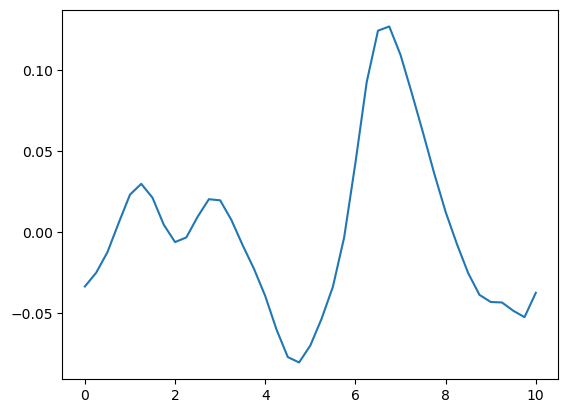

In [9]:

# Create correlation matrix for prior x

H = G_domain.function_space

v2d = dl.vertex_to_dof_map(H)
d2v = dl.dof_to_vertex_map(H)

mesh = G_domain.mesh 


mean_sigma = np.zeros((H.dim(), 1)) #linearization point
corrlength =  0.2 * endpoint
var_sigma = 0.05 ** 2   #prior variance

smprior = SMPrior(mesh.coordinates()[d2v], corrlength, var_sigma, mean_sigma)#, covariancetype='Ornstein-Uhlenbeck')


sample = smprior.draw_samples(1)
fun = dl.Function(H)
fun.vector().set_local(sample)

im = dl.plot(fun)
if physical_dim == 2:
    plt.colorbar(im)






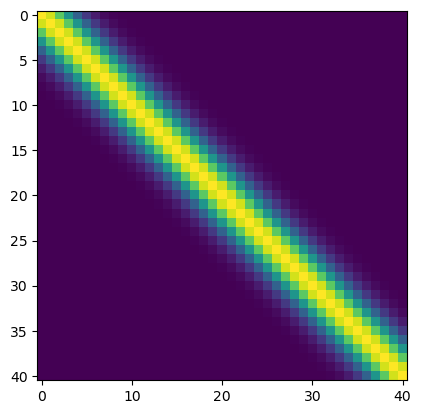

In [10]:
# visualize the covariance matrix 
plt.figure()
plt.imshow(smprior.cov)

In [11]:
x = Gaussian(np.zeros(G_domain.par_dim), cov=100*smprior.cov, geometry=G_domain)

In [12]:
# Set the random seed
np.random.seed(3) 

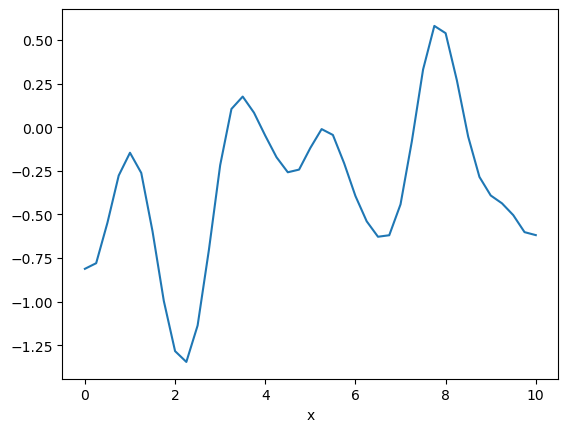

In [13]:
x_true = x.sample()
im = x_true.plot()
if physical_dim == 2:
    plt.colorbar(im[0])



This cell to compute s_noise

In [14]:
noise_level = 0.01
y_true = A(x_true)
s_noise = 1.0/np.sqrt(G_domain.par_dim)* noise_level*np.linalg.norm(y_true)

[[<matplotlib.lines.Line2D at 0x194d0cac0>]]

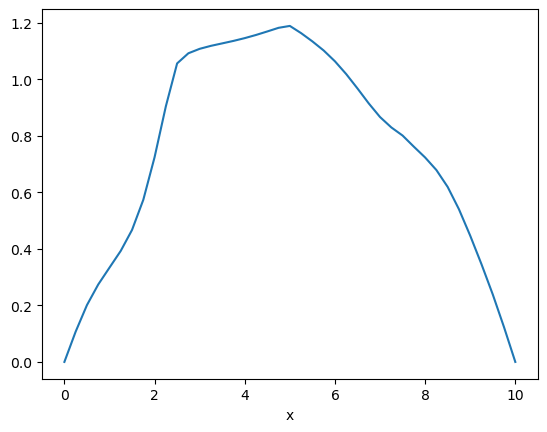

In [15]:
y_true.plot()

In [16]:
y = Gaussian(A(x), s_noise**2, geometry=G_range)

[[<matplotlib.lines.Line2D at 0x194d33970>]]

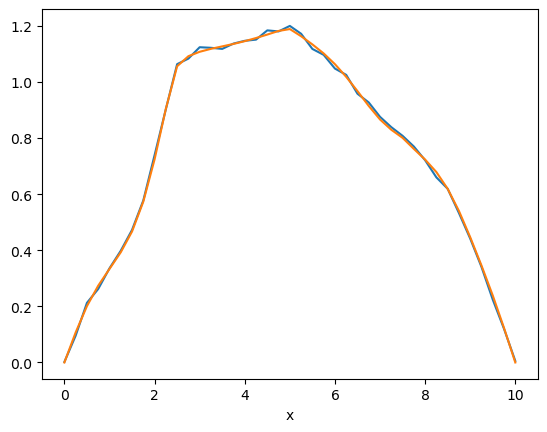

In [17]:
y_obs = y(x=x_true).sample()
y_obs.plot()
y_true.plot()

In [18]:
BP = BayesianProblem(y, x).set_data(y=y_obs)

In [19]:
#posterior_samples = BP.UQ(Ns=3000, Nb=2, percent=97)
posterior = BP.posterior()
#sampler = cuqi.sampler.NUTS(posterior, max_depth=4, x0=np.zeros(G_domain.par_dim)+.001)
#sampler = cuqi.sampler.ULA(posterior, x0=np.zeros(G_domain.par_dim)+.001, scale=0.00000005)
# np.zeros(G_domain.par_dim)+.001
initial_point = np.zeros(G_domain.par_dim) # x_true.to_numpy()
sampler = cuqi.experimental.mcmc.PCN(posterior, initial_point=initial_point, scale=0.05)#, max_depth=10, scale=0.005)
Ns = 2500
Nb = 600
Nb_extra = 0
_ = sampler.warmup(Nb)
_ = sampler.sample(Ns)


#posterior_samples = sampler.sample_adapt(100, Nb=10)

Sample: 100%|██████████| 2500/2500 [00:30<00:00, 81.21it/s, acc rate: 23.28%]


In [20]:
posterior_samples = sampler.get_samples().burnthin(Nb+Nb_extra)

In [21]:
sampler.scale

0.021089466281791786

Code cell for generating Figure 1

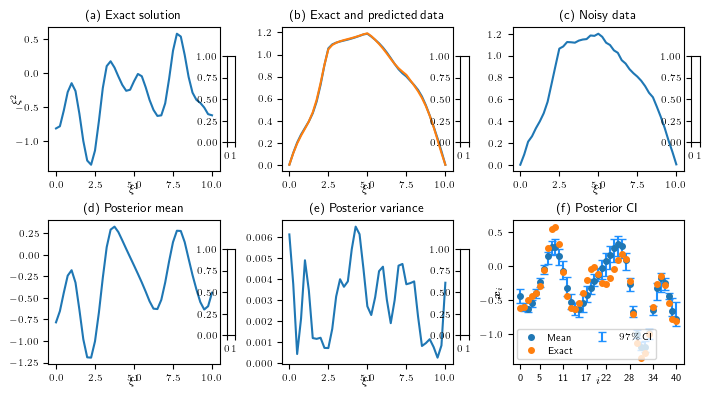

In [22]:


import os
from matplotlib import ticker
import matplotlib.pyplot as plt

# Set up matplotlib
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Use latex package
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')

# Data directory
fig_dir = './figs/'

# Figure file
fig_dir = fig_dir 

# Check if the directory exists
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Figure version
version = 'v8'

# Figure file
fig_file = fig_dir + 'paper_figure1_'+version+'.pdf'

# Create the figure
cm_to_in = 1/2.54
fig, axs = plt.subplots(nrows=2, ncols=3,
                        figsize=(17.8*cm_to_in, 9.8*cm_to_in),
                        layout="constrained")

# Define the colors to be used in the plots
colors = ['C0', 'green', 'purple', 'k', 'gray']

# (a)
plt.sca(axs[0,0])
im = x_true.plot(subplots=False)#, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
if physical_dim == 2: 
    fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    plt.gca().set_ylim(0, 1)

#plt.gca().set_xlim(0, 1)
plt.gca().set_title('(a) Exact solution')
plt.ylabel('$\\xi^2$')
plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5

# (b)
plt.sca(axs[0,1])
im = y_true.plot(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])

if physical_dim == 2:
    fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5
    plt.gca().set_title('(b) Exact data')
else:
    samples_mean = cuqi.array.CUQIarray(posterior_samples.mean(), geometry=G_domain)
    A(samples_mean).plot(subplots=False)
    plt.gca().set_title('(b) Exact and predicted data')
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5


# (c)
plt.sca(axs[0,2])
im = y_obs.plot(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
if physical_dim == 2:
    fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(c) Noisy data')

# (d)
plt.sca(axs[1,0])
im = posterior_samples.plot_mean(
    subplots=False)#, vmin=-0.2, vmax=0.5, mode='color')
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
if physical_dim == 2:
    fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    plt.gca().set_ylim(0, 1)
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5

#plt.gca().set_xlim(0, 1)
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(d) Posterior mean')

# (e)
plt.sca(axs[1,1])
im = posterior_samples.funvals.vector.plot_variance(subplots=False)
inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])

if physical_dim == 2:
    cb = fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
    cb.locator = ticker.MaxNLocator(nbins=4)
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5
plt.xlabel('$\\xi^1$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(e) Posterior variance')

# (f)
plt.sca(axs[1,2])
lci = posterior_samples.plot_ci(
    97, exact=x_true, plot_par=True, markersize=SMALL_SIZE-3)
lci[0].set_label("Mean")
lci[1].set_label("Exact")
lci[2].set_label("$97\\%$ CI")
#plt.ylim(-5, 3)
plt.legend(ncols=2) 
plt.ylabel(r'$\bm{x}_i$')
plt.gca().yaxis.labelpad = -5
plt.gca().yaxis.set_label_coords( -0.06, 0.5)
plt.xlabel('$i$')
plt.gca().xaxis.labelpad = -5
plt.gca().set_title('(f) Posterior CI')
n_ticks = 8
num_var = posterior_samples.geometry.par_dim
tick_ids = np.linspace(0, num_var-1, n_ticks, dtype=int)
plt.xticks(tick_ids, tick_ids)

# Save the figure
plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=1200)

In [23]:
posterior_samples.compute_ess()

array([ 1.43682694,  1.89440816,  3.29779055,  7.18321414,  6.0001278 ,
        2.05706033,  3.68472847,  7.21067309,  4.41830932,  4.04154633,
        8.20861597, 10.91776388,  5.59202614, 12.01953517, 10.72191578,
       10.10260043,  8.72121978,  8.13696032,  9.056408  , 10.47780711,
       10.60209407, 10.34055159, 10.73710288,  1.47543457, 12.33258256,
       12.49088041,  2.13109814,  1.6521281 ,  8.58211586,  2.64250657,
        1.51787947,  1.53625235, 10.98476243,  1.54993368,  1.51217166,
        1.45329559,  2.06983819, 10.53374257,  2.68184388,  1.53960318,
        1.49277531])

Selecting 5 randomly chosen variables


array([[<AxesSubplot: title={'center': 'x13'}>,
        <AxesSubplot: title={'center': 'x13'}>],
       [<AxesSubplot: title={'center': 'x2'}>,
        <AxesSubplot: title={'center': 'x2'}>],
       [<AxesSubplot: title={'center': 'x3'}>,
        <AxesSubplot: title={'center': 'x3'}>],
       [<AxesSubplot: title={'center': 'x31'}>,
        <AxesSubplot: title={'center': 'x31'}>],
       [<AxesSubplot: title={'center': 'x37'}>,
        <AxesSubplot: title={'center': 'x37'}>]], dtype=object)

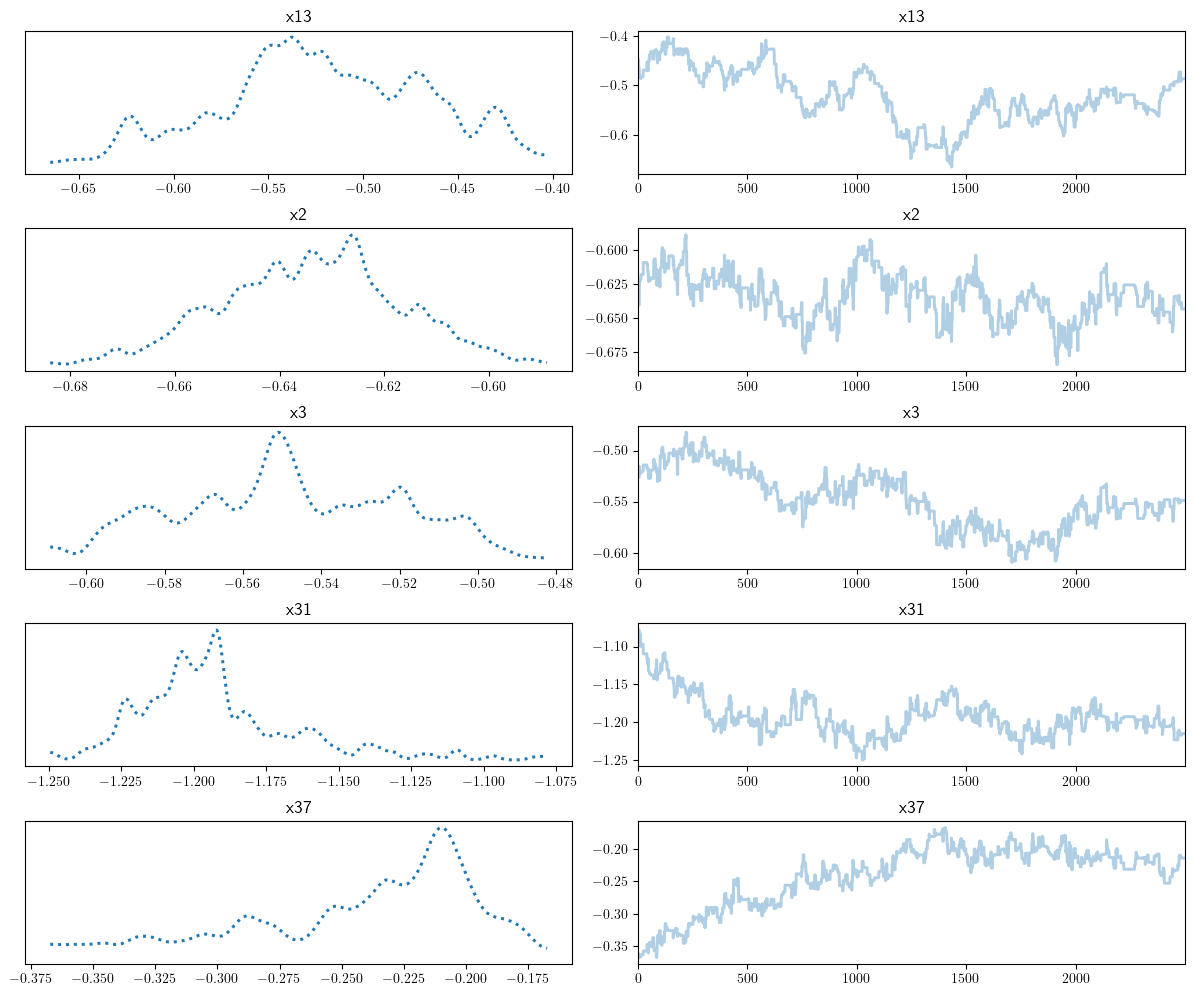

In [24]:
posterior_samples.plot_trace()

Plotting 5 randomly selected samples


[[<matplotlib.lines.Line2D at 0x197148310>],

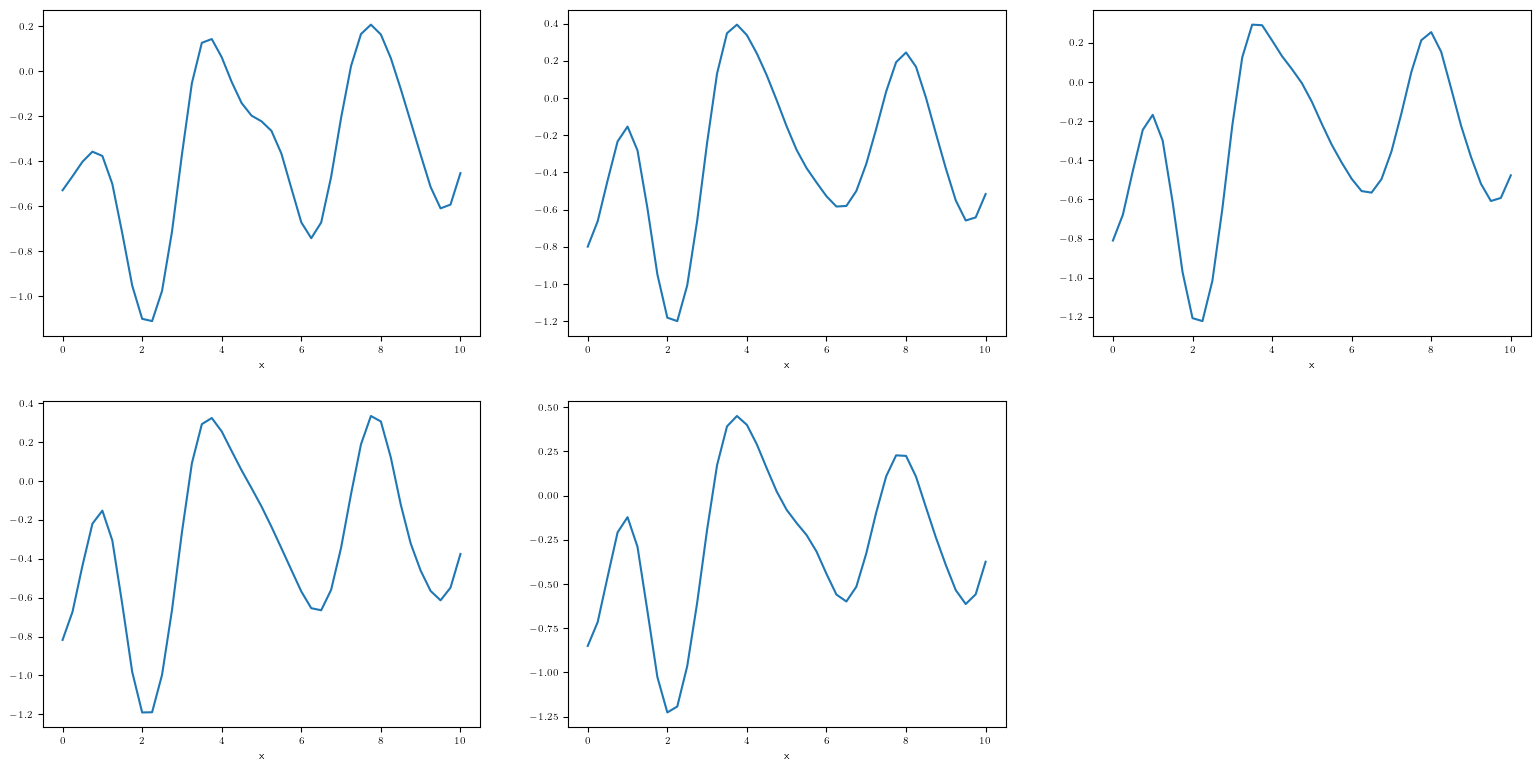

In [25]:
posterior_samples.plot()

In [26]:
# 1D case 
# DG0
# TV with non-MY gradient and with NUTS 
# verify the gradient of the posterior
# PCN seems to work
# Start from x0=the true parameter to debug